# Red Leak Fractions

Isaac Cheng - April 2022

This notebook briefly explores CASTOR's red leak performance.


In [1]:
import pandas as pd
import astropy.units as u
import matplotlib.pyplot as plt

from castor_etc.telescope import Telescope
from castor_etc.sources import PointSource
from castor_etc.background import Background
from castor_etc.photometry import Photometry

Check which version of the `castor_etc` package we are using.


In [2]:
from importlib.metadata import version
version("castor_etc")


'1.0.0'

## Red Leak Introduction

To introduce the concept of _red leak_ and _red leak thresholds_, we will first plot the
telescope's passband response curves. These curves show the total throughput in each
passband and they already include the quantum efficiency conversion (i.e., they convert
from photon flux to electron flux).


In [3]:
# 
# Initialize the Telescope with default passband curves
# 
MyTelescope = Telescope()


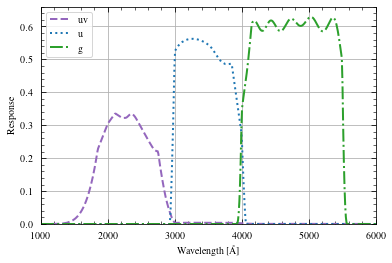

In [4]:
# 
# Plot the curves
# 
# Set line properties for each of the UV-, u-, and g-bands
colors = ["tab:purple", "tab:blue", "tab:green"]
linestyles = ["--", ":", "-."]
# 
fig, ax = plt.subplots()
for band, color, ls in zip(MyTelescope.full_passband_curves, colors, linestyles):
    ax.plot(
        MyTelescope.full_passband_curves[band]["wavelength"].to(u.AA).value,
        MyTelescope.full_passband_curves[band]["response"],
        color=color,
        ls=ls,
        lw=2,
        label=band,
    )
ax.set_xlim(1000, 6000)
ax.set_ylim(bottom=0)
ax.set_xlabel(r"Wavelength [\AA]")
ax.set_ylabel("Response")
ax.legend()
plt.show()


For our purposes, it is actually more useful to plot the passband response curves on a
logarithmic scale, as shown below.


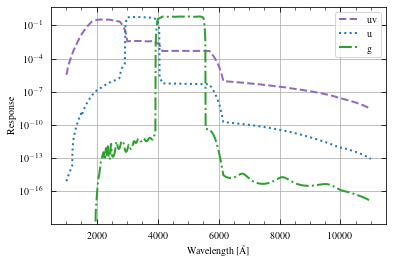

In [5]:
# 
# Plot the curves
# 
# Set line properties for each of the UV-, u-, and g-bands
colors = ["tab:purple", "tab:blue", "tab:green"]
linestyles = ["--", ":", "-."]
# 
fig, ax = plt.subplots()
for band, color, ls in zip(MyTelescope.full_passband_curves, colors, linestyles):
    ax.plot(
        MyTelescope.full_passband_curves[band]["wavelength"].to(u.AA).value,
        MyTelescope.full_passband_curves[band]["response"],
        color=color,
        ls=ls,
        lw=2,
        label=band,
    )
# ax.set_xlim(1000, 6000)
ax.semilogy()
ax.set_xlabel(r"Wavelength [\AA]")
ax.set_ylabel("Response")
ax.legend()
plt.show()


The following shows the `[start, stop]` nominal wavelength range for each passband.


In [6]:
MyTelescope.passband_limits

{'uv': <Quantity [0.15, 0.3 ] um>,
 'u': <Quantity [0.3, 0.4] um>,
 'g': <Quantity [0.4 , 0.55] um>}

But we can see from the log-scale plot above that the passband response does not
immediately drop to zero outside these wavelength ranges. In general, CCD and CMOS
detectors are very sensitive to light at the optical wavelengths. For a telescope
operating in the UV and blue-optical regimes, mitigating the excess response at these
redder wavelengths—a phenomenon known as _red leak_—can be a challenge and a significant
source of noise in measurements.

Thus, for each passband, we define a _red leak threshold_. Any detector response induced
by the source longward of this wavelength is considered red leak. In an ideal world, the
red leak threshold would be identical to the passband's nominal wavelength range's upper
limit. In practice, the detector response usually does not drop to "background" levels
until slightly beyond the nominal wavelength range. We seek to identify the wavelength
(i.e., the red leak threshold) at which we can reasonably say that we are outside the
passband.

We visually identified the red leak threshold for each passband and our results are
displayed below.


In [7]:
MyTelescope.redleak_thresholds

{'uv': <Quantity 3010. Angstrom>,
 'u': <Quantity 4160. Angstrom>,
 'g': <Quantity 5600. Angstrom>}

Below, we show an example demonstrating the offset between the g-band's nominal
wavelength range's upper limit and the chosen red leak threshold. Notice that the
passband's nominal upper wavelength limit is still clearly within the passband, hence the
need for a separate red leak threshold quantity.


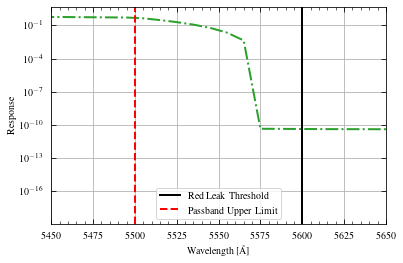

In [8]:
BAND_TO_PLOT = "g"

fig, ax = plt.subplots()
ax.plot(
    MyTelescope.full_passband_curves[BAND_TO_PLOT]["wavelength"].to(u.AA).value,
    MyTelescope.full_passband_curves[BAND_TO_PLOT]["response"],
    color="tab:green",
    ls="-.",
    lw=2,
)
ax.axvline(
    MyTelescope.redleak_thresholds[BAND_TO_PLOT].to(u.AA).value,
    color="k",
    ls="-",
    lw=2,
    label="Red Leak Threshold",
)
ax.axvline(
    MyTelescope.passband_limits[BAND_TO_PLOT][1].to(u.AA).value,
    color="r",
    ls="--",
    lw=2,
    label="Passband Upper Limit",
)
ax.set_xlim(5450, 5650)
ax.semilogy()
ax.set_xlabel(r"Wavelength [\AA]")
ax.set_ylabel("Response")
ax.legend()
plt.show()


Finally, note that there is not a single, objectively "correct" value for a red leak
threshold. Red leak is simply a way to estimate the excess, unwanted response in a
passband. Red leak itself is not an actual, mathematical term in signal-to-noise
calculations; instead, red leak is implicitly included in the shot noise due to the
intrinsic flux of the source. As always, users can always change the red leak threshold to
see how it affects the calculated red leak fraction (discussed below), but again, this
will not affect signal-to-noise calculations.


## CASTOR's Red Leak Performance


In [9]:
from IPython.core.display import display


We will now calculate the red leak fraction in each of CASTOR's passbands for blackbodies
of various effective temperatures. A passband's _red leak fraction_ is the ratio of the
detector response (in electron/s) caused by flux longward of the red leak threshold
(discussed above) relative to the total response induced by the source.


In [10]:
#
# Create source (normalization cancels out in red leak fraction calculation)
#
bb_temps = [3000, 4000, 5000, 7000, 10000, 15000, 20000, 30000, 40000, 50000]  # kelvin
redleak_fracs = dict.fromkeys(bb_temps)

MyBackground = Background()
MySource = PointSource()

for temp in bb_temps:
    MySource.generate_bb(temp, overwrite=True, quiet=True)
    MyPhot = Photometry(MyTelescope, MySource, MyBackground)
    redleak_fracs[temp] = MyPhot.calc_redleak_frac()

redleak_fracs = pd.DataFrame(redleak_fracs).transpose()
redleak_fracs = redleak_fracs.rename_axis("T [K]", axis="index")
with pd.option_context("display.float_format", "{:.1e}".format):
    display(redleak_fracs)

,uv,u,g
T [K],,,
3000,7.9e-01,2.1e-05,2.1e-11
4000,3.6e-01,7.9e-06,1.5e-11
5000,1.7e-01,4.4e-06,1.2e-11
7000,5.6e-02,2.3e-06,9.1e-12
10000,2.3e-02,1.4e-06,7.4e-12
15000,1.1e-02,9.6e-07,6.3e-12
20000,7.9e-03,8.1e-07,5.9e-12
30000,5.6e-03,7.0e-07,5.5e-12
40000,4.8e-03,6.5e-07,5.3e-12


We will also plot the red leak fractions.


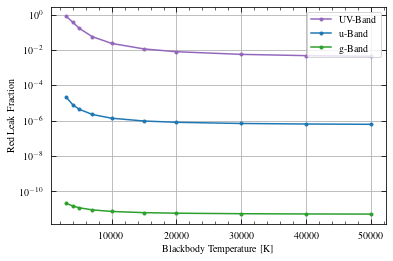

In [11]:
fig, ax = plt.subplots()
ax.plot(bb_temps, redleak_fracs["uv"], ".-", color="tab:purple", label="UV-Band")
ax.plot(bb_temps, redleak_fracs["u"], ".-", color="tab:blue", label="u-Band")
ax.plot(bb_temps, redleak_fracs["g"], ".-", color="tab:green", label="g-Band")
ax.semilogy()
ax.set_xlabel("Blackbody Temperature [K]")
ax.set_ylabel("Red Leak Fraction")
ax.legend()
plt.show()